<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br><b>Introduction to the DP0.3 Moving Object Catalogs</b> <br>
Contact author: Bob Abel and Douglas Tucker<br>
Last verified to run: 2023-06-27 <br>
LSST Science Piplines version: Weekly 2023_21 <br>
Container size: medium <br>
Targeted learning level: beginner <br>

In [1]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

**Description:** DP0.3 moving object catalogs are examined.

**Skills:** Discover moving object catalogs and create plots for preliminary analysis. 

**LSST Data Products:** TAP dp03_catalogs.

**Packages:** lsst.rsp.get_tap_service, lsst.rsp.retrieve_query, numpy, matplotlib

**Credit:**
Mario Jurić and literally every single contributing author to the Rubin Stack Club, DP0 Tutorial, and Delegate Contribution, Jupyter Notebooks, and Jake Vanderplas.

**Get Support:**
Find DP0.3-related documentation and resources at <a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook will teach the user about the basic constituents of the DP0.3 data set.  DP0.3 consists of both real and simulated solar system objects (asteroids, near-earth objects, Trojans, trans-Neptunian objects, and even a simulated spaceship... but no comets, major planets, or the Moon).  It is a hybrid catalog in which objects from the Minor Planet Center have replaced objects with similar properties from the original simulated data set.  

Due to time and effort constraints, only catalog data are available.  Also, since the DP0.2 footprint is far from the ecliptic plane, only a very small fraction of DP0.3 would appear within a DP0.2 visit.  (For those interested, please see notebook **XX** for inserting an DP0.3 object into the appropriate DP0.2 visit calexp image.)

For the real objects in the DP0.3, one should consult the `MPCORB` provided instead of querying the actual the Minor Planet Center (see below).

For additional information, please consult 
<a href="https://dp0-3.lsst.io">dp0-3.lsst.io</a>.


### 1.1 Package Imports

Import general python packages and the Rubin TAP service utilities.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import pandas as pd

from lsst.rsp import get_tap_service, retrieve_query

### 1.2 Define Functions and Parameters

Here, we define a function, `estDistFromHandAlbedo`, which estimates the diameter (in km) of an solar system object based on its solar system absolute magnitude, H, and its albedo, a.  It assumes a spherical body and is just a rough estimate.  We will use it later.

We obtained this function from https://cneos.jpl.nasa.gov/tools/ast_size_est.html, and we take as a default albedo an albedo of a=0.15, which is not atypical for, say, an S-class asteroid.

In [3]:
def estDiamFromHandAlbedo(H, a=0.15):
    import numpy as np
    estDiam = np.power(10., 3.1236 - 0.5*np.log10(a) - 0.2*H)
    return estDiam

## 2. Create the Rubin SSO TAP Service client

Get an instance of the SSO TAP service, and assert that it exists.

_Note that the DP0.3 TAP service for DP0.3 is "ssotap", **not** "tap" (which is used for DP0.2)._ 

In [4]:
service = get_tap_service("ssotap")
assert service is not None

### 2.1 What are the Moving Object Schemas?

Let's take a look at which schemas are available in DP0.3.

In [5]:
query = "SELECT * FROM tap_schema.schemas"
results = service.search(query)
print(type(results))

<class 'pyvo.dal.tap.TAPResults'>


In [6]:
results = service.search(query).to_table().to_pandas()
results

,description,schema_index,schema_name,utype
0,Data Preview 0.3 contains the catalog products...,0,dp03_catalogs,
1,A TAP-standard-mandated schema to describe tab...,100000,tap_schema,
2,UWS Metadata,120000,uws,


We see that there is a dp03_catalogs schema.  If there were more schemas in the DP0.3 database, we could use the following to find the dp03 schemas specifically:

In [7]:
schema_names = results['schema_name']
for name in schema_names:
    if name.find('dp03') > -1:
        dp03_schema_name = name
        break
print("DP0.3 schema is " + dp03_schema_name)

DP0.3 schema is dp03_catalogs


### 2.2 What are in the DP0.3 catalogs?

Let's take a quick look at the meta-information for the tables in the `dp03_catalogs` schema.  In the following sections, we will look closer at each of these tables in more detail.

In [8]:
query = "SELECT * FROM tap_schema.tables " \
        "WHERE tap_schema.tables.schema_name = '" \
        + dp03_schema_name + "' order by table_index ASC"
print(query)

results = service.search(query)
results = results.to_table()
results

SELECT * FROM tap_schema.tables WHERE tap_schema.tables.schema_name = 'dp03_catalogs' order by table_index ASC


description,schema_name,table_index,table_name,table_type,utype
str512,str512,int32,str64,str8,str512
The orbit catalog produced by the Minor Planet Center. Ingested daily. O(10M) rows by survey end. The columns are described at https://minorplanetcenter.net//iau/info/MPOrbitFormat.html,dp03_catalogs,0,dp03_catalogs.MPCORB,table,
"LSST-computed per-object quantities. 1:1 relationship with MPCORB. Recomputed daily, upon MPCORB ingestion.",dp03_catalogs,0,dp03_catalogs.SSObject,table,
"LSST-computed per-source quantities. 1:1 relationship with DIASource. Recomputed daily, upon MPCORB ingestion.",dp03_catalogs,0,dp03_catalogs.SSSource,table,
Table to store 'difference image sources'; - sources detected at SNR >=5 on difference images.,dp03_catalogs,0,dp03_catalogs.DiaSource,table,


## 3. What's in the MPCORB catalog and how big is it?

Let's first take a look at the `MPCORB` table, which provides an version of the Minor Planet Center orbit catalog relevant for the epochs of the Rubin DP0.3 catalog.

In [9]:
results = service.search("SELECT COUNT(*) from dp03_catalogs.MPCORB")
results.to_table().to_pandas()

,COUNT
0,14600302


There are 14.6M rows. Let's pull out 1% of those, which would be about 43,000 rows. In order to extract data at random, we'll grab a sequence of the ssObjectId's, since they are currently random.

For the moment, we can do this mostly simply by making use of a temporary trick associated with the current version of the prompt processing data products:  the fact that `ssObjectId` is a randomly assigned 64-bit long unsigned integer.  (Note:  since ADQL interprets a 64-bit long unsigned integer as a 63-bit _signed_ integer, these range from a very large negative integer value to a very large positive integer value.)  To grab a random sample we grab objects over a relatively small range of values of `ssObjectId`.  

In [10]:
results = service.search("SELECT max(ssObjectId), min(ssObjectId) from dp03_catalogs.MPCORB")

min = int(results[0].get('min'))
max = int(results[0].get('max'))
print('Absolute min, max = ', min, max)
min = int(max - (0.01 * max))
print('1% min, max (from top) = ', min, max)

Absolute min, max =  -9223370383071521539 9223370875126069107
1% min, max (from top) =  9131137166374808576 9223370875126069107


OK, we will grab a random 1% of objects from the `MPCORB` table, making use of the range of `ssObjectId` values we have just found.  (Actually, we will grab a _maximum_ of 1% of objects from the MPCORB table, since the random numbers are not continuous.)

(_Note that you'll have some warnings from this next query that aren't your fault and will be corrected in the future._)

In [11]:
query = """SELECT *
FROM dp03_catalogs.MPCORB
WHERE ssObjectId < 9223370875126069107 AND ssObjectId > 9131137166374808576"""

df = service.search(query).to_table().to_pandas()
df

,arc,arcEnd,arcStart,computer,e,epoch,flags,fullDesignation,incl,lastIncludedObservation,...,nopp,peri,pertsLong,pertsShort,q,reference,rms,ssObjectId,tperi,uncertaintyParameter
0,NaN,,,,0.570970,54800.000000,0,2011 SR00004K,25.939150,NaN,...,0,350.606980,,,6.113300,,NaN,9185009465900868832,20859.963850,
1,NaN,,,,0.363600,54800.000000,0,2011 SR0000iQ,16.353220,NaN,...,0,147.316050,,,17.303450,,NaN,9136273658435248197,51070.857800,
2,NaN,,,,0.422040,54800.000000,0,2011 SR0000jR,16.453660,NaN,...,0,274.863090,,,6.479600,,NaN,9196671585077870249,28521.104640,
3,NaN,,,,0.639530,54800.000000,0,2011 SR0000sn,15.263050,NaN,...,0,226.268830,,,9.611210,,NaN,9165069355693008015,47926.391840,
4,NaN,,,,0.558600,54800.000000,0,2011 SR0000O9,2.014410,NaN,...,0,342.576070,,,6.387960,,NaN,9204187278771900476,54049.125620,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73194,NaN,,,,0.699330,73349.917495,0,2011 SI00029q,8.924373,NaN,...,0,155.486565,,,1.010904,,NaN,9202444422702896229,72771.929158,
73195,NaN,,,,0.241565,82907.000554,0,2011 SI0002l6,9.715864,NaN,...,0,17.733114,,,0.974737,,NaN,9177118190137388277,83012.719158,
73196,NaN,,,,0.563781,61365.350292,0,2011 SI0002qP,4.110239,NaN,...,0,152.428342,,,0.949081,,NaN,9220586587601309840,61834.429501,
73197,NaN,,,,0.686982,64269.689620,0,2011 SI0002uH,1.053755,NaN,...,0,324.365268,,,0.873964,,NaN,9143316944274961815,65005.664047,


73199 objects have been returned, but 73199 is not 1% of 14600302.  As noted above, this number is less than 1% of the full number of objects in this table, but it is a large enough number for our current purposes; so let's go with it.

Let's now look at the column information for the data frame we have just created:

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73199 entries, 0 to 73198
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   arc                      0 non-null      float32
 1   arcEnd                   73199 non-null  object 
 2   arcStart                 73199 non-null  object 
 3   computer                 73199 non-null  object 
 4   e                        73199 non-null  float64
 5   epoch                    73199 non-null  float64
 6   flags                    73199 non-null  int32  
 7   fullDesignation          73199 non-null  object 
 8   incl                     73199 non-null  float64
 9   lastIncludedObservation  0 non-null      float32
 10  mpcDesignation           73199 non-null  object 
 11  mpcG                     73199 non-null  float32
 12  mpcH                     73199 non-null  float32
 13  mpcNumber                73199 non-null  int32  
 14  n                     

Here, we will run the pandas `describe` command, which will output some basic population distribution information for the numerical columns in this pandas data frame.

In [13]:
df.describe()

,arc,e,epoch,flags,incl,lastIncludedObservation,mpcG,mpcH,mpcNumber,n,nobs,node,nopp,peri,q,rms,ssObjectId,tperi
count,0.0,73199.000000,73199.000000,73199.0,73199.000000,0.0,73199.000000,73199.000000,73199.0,0.0,73199.0,73199.000000,73199.0,73199.000000,73199.000000,0.0,7.319900e+04,73199.000000
mean,NaN,0.172110,54802.108562,0.0,10.972516,NaN,0.150000,20.617748,0.0,NaN,0.0,173.933889,0.0,180.749174,2.440718,NaN,9.177219e+18,52907.166256
std,NaN,0.107582,604.821538,0.0,7.747497,NaN,0.000048,2.177858,0.0,NaN,0.0,104.124171,0.0,104.058915,2.278342,NaN,2.656449e+16,4542.692712
min,NaN,-0.002850,54090.500000,0.0,0.000990,NaN,0.150000,4.760000,0.0,NaN,0.0,0.011650,0.0,0.003060,0.011427,NaN,9.131138e+18,-63479.039930
25%,NaN,0.105540,54800.000000,0.0,5.476765,NaN,0.150000,19.610001,0.0,NaN,0.0,83.464248,0.0,90.570235,1.956780,NaN,9.154215e+18,52026.252475
50%,NaN,0.157540,54800.000000,0.0,9.825610,NaN,0.150000,20.900000,0.0,NaN,0.0,167.619030,0.0,181.001910,2.199550,NaN,9.177232e+18,53802.537050
75%,NaN,0.211480,54800.000000,0.0,14.184560,NaN,0.150000,22.040001,0.0,NaN,0.0,264.384020,0.0,271.618820,2.574720,NaN,9.200119e+18,54421.666745
max,NaN,0.999930,90936.183867,0.0,154.846880,NaN,0.150000,26.540001,0.0,NaN,0.0,359.992530,0.0,359.994620,45.345770,NaN,9.223370e+18,112667.605180


There are several columns that only contain 'NaN' values.  Let's drop these columns:

In [14]:
df.dropna(axis=1, how='all', inplace=True)

Let's also drop any columns that contain only one distinct value (e.g., all columns are ' ' or all columns are 0).  We note that `mpcG` is one of the columns that will be dropped, since it was set to 0.15 for all the rows.

In [15]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col, inplace=True, axis=1)

Let's see what columns remain.

In [16]:
df.columns

Index(['e', 'epoch', 'fullDesignation', 'incl', 'mpcDesignation', 'mpcH',
       'node', 'peri', 'q', 'ssObjectId', 'tperi'],
      dtype='object')

Let's make some histograms for some of the remaining numerical columns.

Text(0.5, 0.98, 'Some MPCORB Histograms')

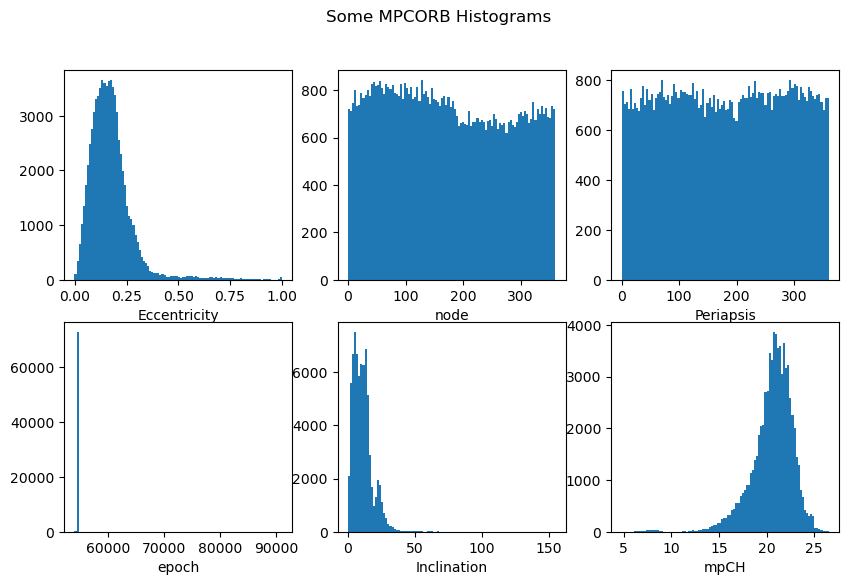

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
ax[0, 0].hist(df['e'], bins=100)
ax[0, 0].set_xlabel('Eccentricity')
ax[0, 1].hist(df['node'], bins=100)
ax[0, 1].set_xlabel('node')
ax[0, 2].hist(df['peri'], bins=100)
ax[0, 2].set_xlabel('Periapsis')
ax[1, 0].hist(df['epoch'], bins=100)
ax[1, 0].set_xlabel('epoch')
ax[1, 1].hist(df['incl'], bins=100)
ax[1, 1].set_xlabel('Inclination')
ax[1, 2].hist(df['mpcH'], bins=100)
ax[1, 2].set_xlabel('mpCH')
fig.suptitle('Some MPCORB Histograms')

In [18]:
df['estDiam'] = estDiamFromHandAlbedo(df['mpcH'])

In [19]:
df['estDiam'].describe()

count    73199.000000
mean         0.863339
std          7.144726
min          0.016887
25%          0.134139
50%          0.226754
75%          0.410728
max        383.313629
Name: estDiam, dtype: float64

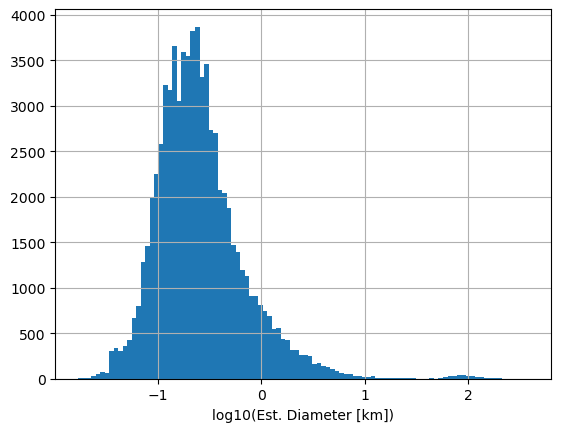

In [20]:
plt.hist(np.log10(df['estDiam']), bins=100)
plt.xlabel('log10(Est. Diameter [km])')
plt.grid(True)


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-1.77244568, -1.72888568, -1.68532568, -1.64176568, -1.59820568,
        -1.55464568, -1.51108568, -1.46752568, -1.42396568, -1.38040568,
        -1.33684568, -1.29328568, -1.24972569, -1.20616569, -1.16260569,
        -1.11904569, -1.07548569, -1.03192569, -0.98836569, -0.94480569,
        -0.90124569, -0.85768569, -0.81412569, -0.77056569, -0.72700569,
        -0.68344569, -0.63988569, -0.59632569, -0.55276569, -0.50920569,
        -0.46564569, -0.4220857 , -0.3785257 , -0.3349657 , -0.2914057 ,
        -0.2478457 , -0.2042857 , -0.1607257 , -0.1171657 , -0.0736057 ,
        -0.0300457 ,  0.0135143 ,  0.0570743 ,  0.1006343 ,  0.1441943 ,
         0.1877543 ,  0.2313143 ,  0.2748743 ,  0.3184343 ,  0.3619943 ,
         0.40555429, 

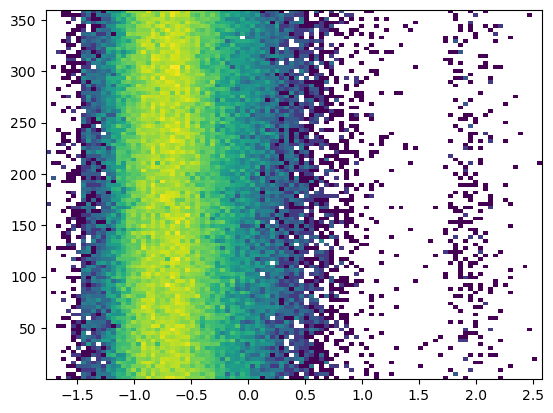

In [21]:
plt.hist2d(np.log10(df['estDiam']), df['peri'], bins=100, norm='log')

(array([ 1.,  0.,  1.,  0.,  2.,  1.,  1.,  2.,  2.,  2.,  3.,  5.,  4.,
         4.,  8.,  2., 13., 10.,  3.,  4.,  7., 17.,  9., 13.,  5.,  5.,
         4.,  7.,  4.,  2.,  4.,  1.,  8.,  6.,  2.,  4.,  3.,  2.,  5.,
         6.,  1.,  3.,  5.,  2.,  3.,  1.,  0.,  0.,  0.,  2.,  0.,  4.,
         0.,  0.,  1.,  0.,  0.,  0.,  2.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([-1.44844592, -1.41496587, -1.38148594, -1.34800589, -1.31452596,
        -1.28104591, -1.24756587, -1.21408594, -1.18060589, -1.14712584,
        -1.11364591, -1.08016586, -1.04668593, -1.01320589, -0.9797259 ,
        -0.94624585, -0.91276586, -0.87928587, -0.84580588, -0.81232584,
        -0.77884585, -0.74536586, -0.71188587, -0.67840582, -0.64492583,
        -0.61144584, -0.57796586, -0.54448587, -0.51100582, -0.477525

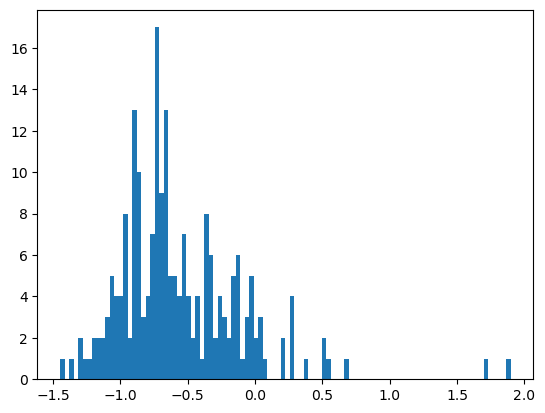

In [22]:
mask = df['peri'] < 1.0
plt.hist(np.log10(df['estDiam'][mask]),bins=100)

Let's also look at some 2D histograms for eccentricity, nodes, and inclination values.

Text(0.5, 0.98, 'Eccentricity, Node and Inclination')

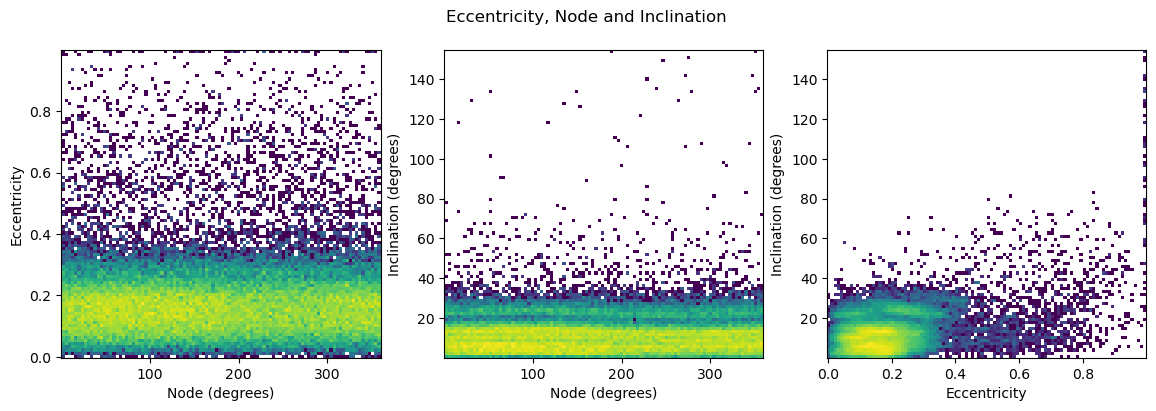

In [23]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))
ax[0].hist2d(df['node'], df['e'], bins=100, norm='log')
ax[0].set_xlabel('Node (degrees)')
ax[0].set_ylabel('Eccentricity')
ax[1].hist2d(df['node'], df['incl'], bins=100, norm='log')
ax[1].set_xlabel('Node (degrees)')
ax[1].set_ylabel('Inclination (degrees)')
ax[2].hist2d(df['e'], df['incl'], bins=100, norm='log')
ax[2].set_xlabel('Eccentricity')
ax[2].set_ylabel('Inclination (degrees)')
fig.suptitle("Eccentricity, Node and Inclination")

Text(0.5, 1.0, 'Asteroid Semi-Major Axis vs. Eccentricity')

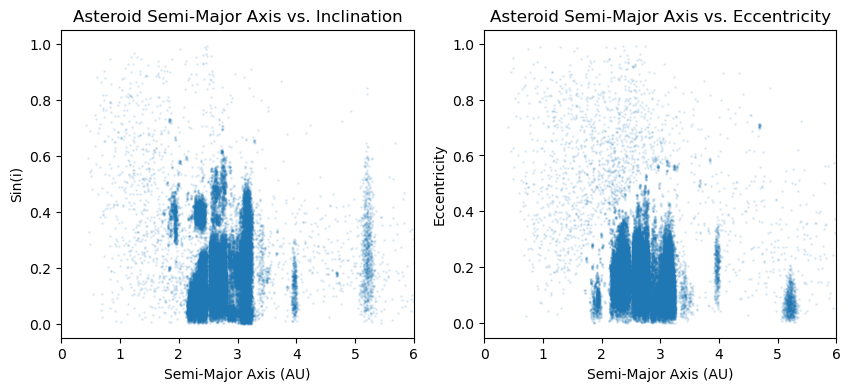

In [24]:
df['semi'] = df['q']/(1. - df['e'])
fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].scatter(df['semi'], np.sin(np.pi / 180. * df['incl']), alpha=0.1, s=1)
ax[0].set_xlim(0, 6)
ax[0].set_xlabel('Semi-Major Axis (AU)')
ax[0].set_ylabel('Sin(i)')
ax[0].set_title('Asteroid Semi-Major Axis vs. Inclination') 

ax[1].scatter(df['semi'], df['e'], alpha=0.1, s=1)
ax[1].set_xlim(0, 6)
ax[1].set_xlabel('Semi-Major Axis (AU)')
ax[1].set_ylabel('Eccentricity')
ax[1].set_title('Asteroid Semi-Major Axis vs. Eccentricity') 


## 4. What's in the SSObject catalog and how big is it?

Now let's look at the `SSObject` table.

In [25]:
results = service.search("SELECT COUNT(*) from dp03_catalogs.SSObject")
results.to_table().to_pandas()

,COUNT
0,10222593


As before, we will consider a random set of objects based on their `ssObjectId` values.

In [26]:
query = """SELECT *
FROM dp03_catalogs.ssObject
WHERE ssObjectId < 9223370875126069107 AND ssObjectId > 9131137166374808576"""

df = service.search(query).to_table().to_pandas()
df.head()

,arc,discoverySubmissionDate,firstObservationDate,flags,gChi2,gG12,gG12Err,gH,gH_gG12_Cov,gHErr,...,yH_yG12_Cov,yHErr,yNdata,zChi2,zG12,zG12Err,zH,zH_zG12_Cov,zHErr,zNdata
0,3089.883301,60599.295358,60592.295358,0,1.577042,0.338602,0.202955,21.161713,0.019386,0.106775,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,15.927057,61750.270241,61743.270241,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2.961222,62806.302010,62799.302010,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0.000000,61654.218500,61647.218500,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0
4,3270.825439,60509.383445,60502.383445,0,1.676326,0.051856,0.138421,18.936575,0.018925,0.141764,...,NaN,NaN,0,1.403565,0.171461,0.162144,18.205658,0.016147,0.108125,9


There are 551227 rows.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51227 entries, 0 to 51226
Data columns (total 55 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   arc                      51227 non-null  float32
 1   discoverySubmissionDate  51227 non-null  float64
 2   firstObservationDate     51227 non-null  float64
 3   flags                    51227 non-null  int64  
 4   gChi2                    23898 non-null  float32
 5   gG12                     23898 non-null  float32
 6   gG12Err                  23898 non-null  float32
 7   gH                       23898 non-null  float32
 8   gH_gG12_Cov              23898 non-null  float32
 9   gHErr                    23898 non-null  float32
 10  gNdata                   51227 non-null  int32  
 11  iChi2                    25998 non-null  float32
 12  iG12                     25998 non-null  float32
 13  iG12Err                  25998 non-null  float32
 14  iH                    

In [28]:
df.describe()

,arc,discoverySubmissionDate,firstObservationDate,flags,gChi2,gG12,gG12Err,gH,gH_gG12_Cov,gHErr,...,yH_yG12_Cov,yHErr,yNdata,zChi2,zG12,zG12Err,zH,zH_zG12_Cov,zHErr,zNdata
count,51227.000000,51227.000000,51227.000000,51227.0,23898.000000,23898.000000,23898.000000,23898.000000,2.389800e+04,23898.000000,...,9.554000e+03,9554.000000,51227.000000,16529.000000,16529.000000,16529.000000,16529.000000,1.652900e+04,16529.000000,51227.000000
mean,2237.285645,60877.898365,60870.898365,0.0,1.586080,0.207300,0.148309,19.201159,4.723215e-01,0.067653,...,7.293496e-01,0.079366,8.030062,1.399849,0.242207,0.185852,17.937695,6.459200e-01,0.074233,14.292775
std,1294.815186,811.050318,811.050318,0.0,19.190218,0.537381,4.926117,1.631289,5.825462e+01,0.141413,...,3.454025e+01,0.216811,23.059311,21.845818,0.545157,4.346987,1.590755,4.571084e+01,0.190788,28.426211
min,0.000000,60225.001806,60218.001806,0.0,0.008994,-0.363811,0.000689,7.852705,4.783068e-07,0.000743,...,3.732586e-07,0.000598,0.000000,0.010297,-0.370921,0.000860,7.064597,7.848149e-07,0.000915,0.000000
25%,1443.919800,60335.153720,60328.153720,0.0,0.822909,0.132503,0.020725,18.288822,2.988165e-04,0.015811,...,3.231248e-04,0.017281,0.000000,0.876338,0.138876,0.018814,17.010714,2.625617e-04,0.015322,0.000000
50%,2815.645020,60532.265721,60525.265721,0.0,1.059144,0.161183,0.053647,19.437029,1.963094e-03,0.039965,...,2.098327e-03,0.041917,0.000000,1.056245,0.166425,0.051439,18.123823,1.899837e-03,0.039974,0.000000
75%,3276.733154,61134.358917,61127.358917,0.0,1.358298,0.214254,0.115312,20.333897,8.869050e-03,0.082781,...,1.058173e-02,0.089246,0.000000,1.278377,0.237976,0.122705,19.034119,9.744429e-03,0.086496,15.000000
max,3595.051025,63819.375091,63812.375091,0.0,2641.300293,65.545464,743.270447,25.592363,8.967290e+03,12.064754,...,3.024482e+03,9.891932,749.000000,2797.307861,41.361580,422.916138,24.245218,4.559956e+03,11.004877,544.000000


Let's drop rows that contain any `NaN`'s.

In [29]:
print('Number of rows before dropping all rows with NaNs: %d' %len(df))
df.dropna(inplace=True)
df.reset_index(inplace=True)
print('Number of rows after dropping all rows with NaNs: %d' %len(df))


Number of rows before dropping all rows with NaNs: 51227
Number of rows after dropping all rows with NaNs: 4774


Calculate colors - note that these are all absolute ("H") magnitudes.  (For solar system objects, absolute magnitudes are defined to be for an object 1 A.U. from the Sun and 1 A.U. from the observer, and at a phase angle (the angle Sun-object-Earth) of 0 degrees.)

In [30]:
df['ug'] = df['uH'] - df['gH']
df['gr'] = df['gH'] - df['rH']
df['ri'] = df['rH'] - df['iH']
df['iz'] = df['iH'] - df['zH']
df['zy'] = df['zH'] - df['yH']

Let's plot some color-color diagrams for these objects.

Text(0.5, 0.98, 'Color-Color Plots for SSObject Catalog')

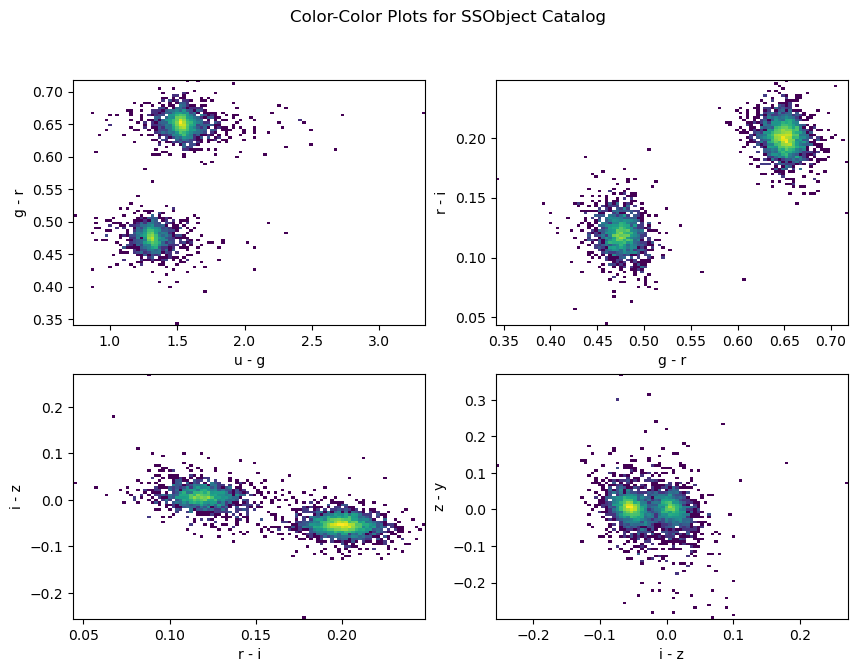

In [31]:
colors = ['ug', 'gr', 'ri', 'iz', 'zy']
filters = ['u', 'g', 'r', 'i', 'z', 'i']
fig, ax = plt.subplots(2, 2, figsize=(10,7))
m = 0
ax[0, 0].hist2d(df['ug'], df['gr'], bins=100, norm='log')
ax[0, 0].set_xlabel('u - g')
ax[0, 0].set_ylabel('g - r')
ax[0, 1].hist2d(df['gr'], df['ri'], bins=100, norm='log')
ax[0, 1].set_xlabel('g - r')
ax[0, 1].set_ylabel('r - i')
ax[1, 0].hist2d(df['ri'], df['iz'], bins=100, norm='log')
ax[1, 0].set_xlabel('r - i')
ax[1, 0].set_ylabel('i - z')
ax[1, 1].hist2d(df['iz'], df['zy'], bins=100, norm='log')
ax[1, 1].set_xlabel('i - z')
ax[1, 1].set_ylabel('z - y')
fig.suptitle('Color-Color Plots for SSObject Catalog')


There are only two populations of colors in the simulation; this will obviously change when we look at the real Solar System. 

Now let's look at the estimated statistical error in the g-band absolute magnitude vs. the g-band absolute magnitude.

Text(0.5, 1.0, 'gHErr vs. gH')

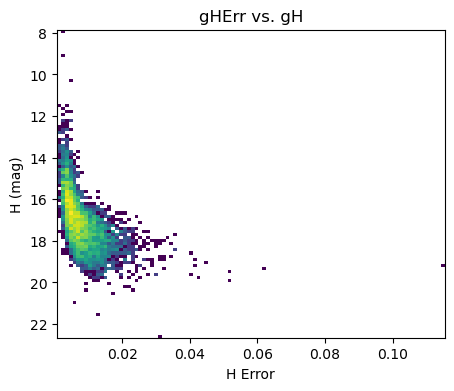

In [32]:
plt.figure(figsize=(5,4))
plt.hist2d(df['gHErr'], df['gH'], bins=100, norm='log')
plt.gca().invert_yaxis()
plt.xlabel('H Error')
plt.ylabel('H (mag)')
plt.title('gHErr vs. gH')

## 5. What's in the SSSource catalog and how big is it?

Now let's look at the `SSSource` table.

In [33]:
results = service.search("SELECT COUNT(*) from dp03_catalogs.SSSource")
results.to_table().to_pandas()

,COUNT
0,1031389589


**_This table contains over a billion sources!_**

As before, we will consider a random set of objects based on their `ssObjectId` values.
Due to the large size of this table, we'll pull a much smaller data set.


In [34]:
minSSSource = int(max - (0.001 * max))
minSSSource

9214147504250943488

In [35]:
query = """SELECT *
FROM dp03_catalogs.SSSource
WHERE ssObjectId < 9223370875126069107 AND ssObjectId > 9214147504250943488"""

df = service.search(query).to_table().to_pandas()
df.head()

,diaSourceId,eclipticBeta,eclipticLambda,galacticB,galacticL,heliocentricDist,heliocentricVX,heliocentricVY,heliocentricVZ,heliocentricX,...,residualDec,residualRa,ssObjectId,topocentricDist,topocentricVX,topocentricVY,topocentricVZ,topocentricX,topocentricY,topocentricZ
0,-2331882174261098207,-11.977874,214.414018,36.672334,319.926573,2.250939,0.002137,-0.010669,-0.005300,-2.165653,...,NaN,NaN,9214148730396380762,2.381151,0.019189,-0.006483,-0.003577,-1.921621,-1.011252,-0.977048
1,867347560563835451,-15.119655,228.103572,25.463550,329.097010,2.255840,0.004214,-0.010336,-0.004617,-2.044600,...,NaN,NaN,9214148730396380762,1.948943,0.014820,0.002563,0.000875,-1.256424,-1.082706,-1.023486
2,4057711316122120355,-17.492563,233.362051,20.162046,330.974123,2.263776,0.005438,-0.009930,-0.004100,-1.928697,...,NaN,NaN,9214148730396380762,1.688748,0.009464,0.005736,0.002600,-0.961168,-0.983861,-0.979817
3,-4559935229320354350,-17.495300,233.365569,20.157722,330.974360,2.263787,0.005439,-0.009930,-0.004099,-1.928556,...,NaN,NaN,9214148730396380762,1.688483,0.009424,0.005720,0.002601,-0.960923,-0.983713,-0.979750
4,-9077906755528548216,-18.699501,234.546349,18.517926,330.821463,2.269094,0.006015,-0.009674,-0.003821,-1.860042,...,NaN,NaN,9214148730396380762,1.573394,0.006459,0.006365,0.003044,-0.864463,-0.913176,-0.945717


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514641 entries, 0 to 514640
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   diaSourceId              514641 non-null  int64  
 1   eclipticBeta             514641 non-null  float64
 2   eclipticLambda           514641 non-null  float64
 3   galacticB                514641 non-null  float64
 4   galacticL                514641 non-null  float64
 5   heliocentricDist         514641 non-null  float32
 6   heliocentricVX           514641 non-null  float32
 7   heliocentricVY           514641 non-null  float32
 8   heliocentricVZ           514641 non-null  float32
 9   heliocentricX            514641 non-null  float32
 10  heliocentricY            514641 non-null  float32
 11  heliocentricZ            514641 non-null  float32
 12  mpcUniqueId              514641 non-null  int64  
 13  phaseAngle               514641 non-null  float32
 14  pred

In [37]:
df.describe()

,diaSourceId,eclipticBeta,eclipticLambda,galacticB,galacticL,heliocentricDist,heliocentricVX,heliocentricVY,heliocentricVZ,heliocentricX,...,residualDec,residualRa,ssObjectId,topocentricDist,topocentricVX,topocentricVY,topocentricVZ,topocentricX,topocentricY,topocentricZ
count,5.146410e+05,514641.000000,514641.000000,514641.000000,514641.000000,514641.000000,514641.000000,514641.000000,514641.000000,514641.000000,...,0.0,0.0,5.146410e+05,514641.000000,514641.000000,514641.000000,514641.000000,514641.000000,514641.000000,514641.000000
mean,-5.952742e+15,-3.701235,208.294930,3.030559,181.262754,3.096603,0.002028,-0.000536,-0.000260,-0.366229,...,NaN,NaN,9.218747e+18,2.318356,0.000286,0.000642,0.000247,-0.298279,-0.356570,-0.291738
std,5.327392e+18,10.615636,95.572246,43.940750,122.584546,3.530645,0.006618,0.007269,0.003538,3.801769,...,NaN,NaN,2.631924e+15,3.548721,0.007399,0.006689,0.003156,3.466460,2.155902,1.003628
min,-9.223370e+18,-78.895823,0.000110,-89.355725,0.000281,0.744730,-0.018952,-0.017738,-0.012280,-40.017704,...,NaN,NaN,9.214149e+18,0.037801,-0.025535,-0.023141,-0.014014,-40.558441,-30.408916,-15.749660
25%,-4.616143e+18,-10.085485,151.349264,-38.152249,46.722281,2.370547,-0.003329,-0.007495,-0.003271,-2.232736,...,NaN,NaN,9.216452e+18,1.538960,-0.005578,-0.004748,-0.002017,-1.528473,-1.250798,-0.632720
50%,-1.154355e+16,-3.226727,212.891568,7.242929,205.266317,2.729405,0.002902,-0.001691,-0.000696,-0.587253,...,NaN,NaN,9.218757e+18,1.921308,-0.000211,0.001059,0.000380,-0.337200,-0.468871,-0.247681
75%,4.607900e+18,3.165067,288.083655,43.040545,294.929465,3.054730,0.007876,0.006801,0.002817,1.767071,...,NaN,NaN,9.221033e+18,2.309346,0.006214,0.005947,0.002517,1.092320,0.611109,0.084729
max,9.223332e+18,39.092158,359.999502,84.298126,359.999691,61.776371,0.020334,0.020581,0.014676,41.551609,...,NaN,NaN,9.223370e+18,62.031693,0.026307,0.024646,0.015050,42.272457,53.308113,24.618116


Text(0.5, 1.0, 'heliocentricDist vs. topocentricDist')

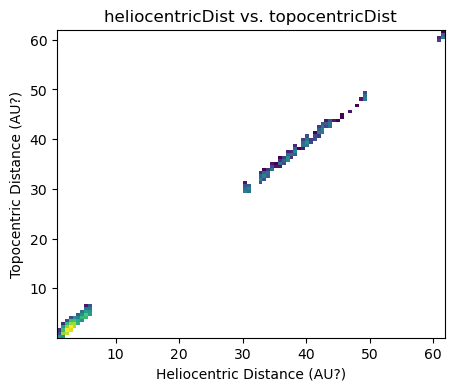

In [38]:
plt.figure(figsize=(5,4))
plt.hist2d(df['heliocentricDist'], df['topocentricDist'], bins=100, norm='log')
plt.xlabel('Heliocentric Distance (AU?)')
plt.ylabel('Topocentric Distance (AU?)')
plt.title('heliocentricDist vs. topocentricDist')

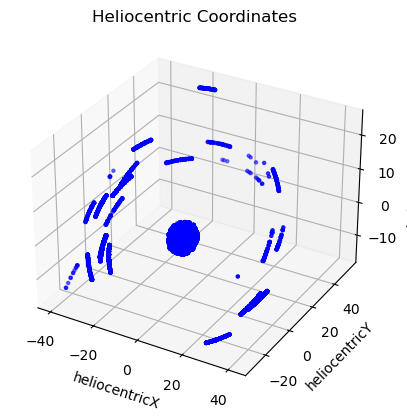

In [39]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['heliocentricX'], df['heliocentricY'], df['heliocentricZ'], c='blue', marker='.')

ax.set_xlabel('heliocentricX')
ax.set_ylabel('heliocentricY')
ax.set_zlabel('heliocentricZ')
ax.set_title("Heliocentric Coordinates")
plt.show()


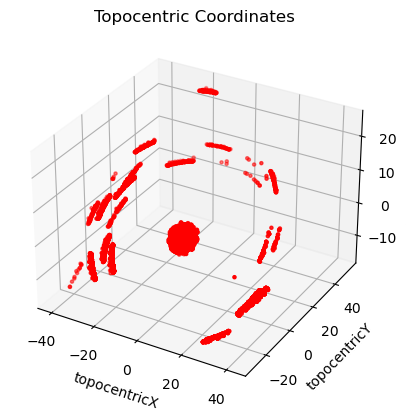

In [40]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['topocentricX'], df['topocentricY'], df['topocentricZ'], c='red', marker='.')

ax.set_xlabel('topocentricX')
ax.set_ylabel('topocentricY')
ax.set_zlabel('topocentricZ')
ax.set_title("Topocentric Coordinates")
plt.show()


Text(0, 0.5, 'Ecliptic β (deg)')

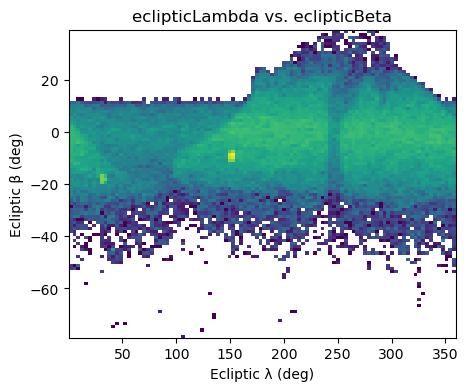

In [41]:
plt.figure(figsize=(5,4))
plt.hist2d(df['eclipticLambda'], df['eclipticBeta'], bins=100, norm='log')
plt.title('eclipticLambda vs. eclipticBeta')
plt.xlabel('Ecliptic λ (deg)')
plt.ylabel('Ecliptic β (deg)')

Text(0, 0.5, 'Galactic Latitude (deg)')

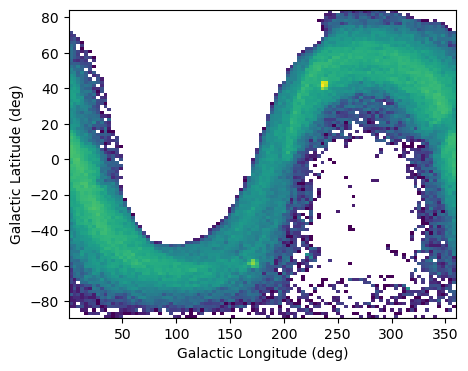

In [42]:
plt.figure(figsize=(5,4))
plt.hist2d(df['galacticL'], df['galacticB'], bins=100, norm='log')
plt.xlabel('Galactic Longitude (deg)')
plt.ylabel('Galactic Latitude (deg)')

In [43]:
df.columns

Index(['diaSourceId', 'eclipticBeta', 'eclipticLambda', 'galacticB',
       'galacticL', 'heliocentricDist', 'heliocentricVX', 'heliocentricVY',
       'heliocentricVZ', 'heliocentricX', 'heliocentricY', 'heliocentricZ',
       'mpcUniqueId', 'phaseAngle', 'predictedDecSigma', 'predictedMagnitude',
       'predictedMagnitudeSigma', 'predictedRaDecCov', 'predictedRaSigma',
       'residualDec', 'residualRa', 'ssObjectId', 'topocentricDist',
       'topocentricVX', 'topocentricVY', 'topocentricVZ', 'topocentricX',
       'topocentricY', 'topocentricZ'],
      dtype='object')

In [44]:
myquery = "SELECT heliocentricX, heliocentricY, topocentricX, topocentricY, ssObjectId" + \
        " FROM dp03_catalogs.SSSource" + \
        " WHERE (ssObjectId =6793512588511170680)"
results = service.search(myquery)
print(type(results))
results = service.search(myquery).to_table().to_pandas()
results

<class 'pyvo.dal.tap.TAPResults'>


,heliocentricX,heliocentricY,topocentricX,topocentricY,ssObjectId
0,-1.120697,-1.627495,-0.506155,-2.333641,6793512588511170680
1,-1.120668,-1.627519,-0.506084,-2.333634,6793512588511170680
2,-1.082890,-1.657938,-0.414987,-2.322733,6793512588511170680
3,-1.082860,-1.657961,-0.414918,-2.322722,6793512588511170680
4,-1.082831,-1.657984,-0.414848,-2.322711,6793512588511170680
...,...,...,...,...,...
482,-0.196160,1.952139,0.624825,1.448362,6793512588511170680
483,-1.003959,1.610761,-0.195555,2.160848,6793512588511170680
484,-1.003991,1.610739,-0.195618,2.160866,6793512588511170680
485,-1.004024,1.610717,-0.195680,2.160884,6793512588511170680


Text(0.5, 1.0, 'Heliocentric XY path of Object 6793512588511170680')

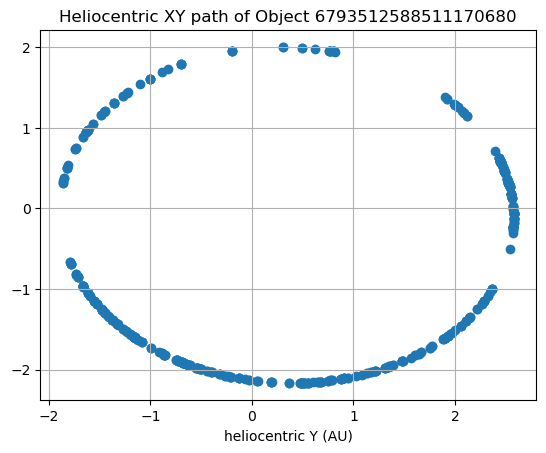

In [45]:
plt.scatter(results['heliocentricX'], results['heliocentricY'])
plt.grid(True)
plt.xlabel('heliocentric X (AU)')
plt.xlabel('heliocentric Y (AU)')
plt.title('Heliocentric XY path of Object 6793512588511170680')

## 6. What's in the DiaSource catalog and how big is it?


In [46]:
results = service.search("SELECT COUNT(*) from dp03_catalogs.DiaSource")
results.to_table().to_pandas()

,COUNT
0,1031389589


Same situation as SSSource - over a billion objects, so use the same limits as for SSSource.

In [47]:
query = """SELECT *
FROM dp03_catalogs.DiaSource
WHERE ssObjectId < 9223370875126069107 AND ssObjectId > 9214147504250943488"""

df = service.search(query).to_table().to_pandas()
df

,_decTrue,_magTrue,_name,_raTrue,_V,ccdVisitId,decl,declSigma,diaObjectId,diaSourceId,filter,mag,magSigma,midPointTai,ra,ra_decl_Cov,raSigma,snr,ssObjectId,ssObjectReassocTime
0,-24.225311,23.053452,S100sanTa,207.755563,23.308453,674480,-24.225271,0.000012,-9194409445772103316,-2331882174261098207,r,23.011091,0.105311,61410.336766,207.755559,0.0,0.000012,9.817913,9214148730396380762,61410.33676566108
1,-31.678294,23.319633,S100sanTa,220.752671,22.924633,698833,-31.678287,0.000004,-6256623948270999662,867347560563835451,g,23.202835,0.051420,61448.322456,220.752679,0.0,0.000004,20.618900,9214148730396380762,61448.32245558813
2,-35.464861,22.956850,S100sanTa,225.668462,22.561850,715404,-35.464856,0.000004,7731624285748347487,4057711316122120355,g,22.909597,0.043292,61472.302620,225.668472,0.0,0.000004,24.582699,9214148730396380762,61472.30261962077
3,-35.468458,22.306400,S100sanTa,225.671436,22.561399,715454,-35.468452,0.000004,-2233634430585881080,-4559935229320354350,r,22.361153,0.036251,61472.328547,225.671433,0.0,0.000004,29.453165,9214148730396380762,61472.32854716052
4,-36.946448,21.941467,S100sanTa,226.569719,22.347467,724652,-36.946441,0.000015,-2049956630163863401,-9077906755528548216,y,21.535053,0.155601,61484.286459,226.569734,0.0,0.000015,6.489630,9214148730396380762,61484.286458514434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514636,-11.521770,23.644299,S100CSIVa,156.034758,23.942299,1531358,-11.521731,0.000025,-6931758784898056707,-4630183780981088497,z,23.021788,0.296010,62901.247000,156.034691,0.0,0.000025,3.190601,9223370323280082057,62901.24699957877
514637,-11.707979,24.278765,S100CSIVa,156.347487,23.976765,1530016,-11.707973,0.000008,-9108440783752730744,1295083018380555837,g,24.082386,0.109329,62899.314036,156.347486,0.0,0.000008,9.439310,9223370323280082057,62899.314036020696
514638,-11.705734,23.804325,S100CSIVa,156.343467,23.976326,1530066,-11.705738,0.000007,4251106071732855350,-7552594750373973562,r,23.672674,0.101137,62899.338382,156.343450,0.0,0.000007,10.243048,9223370323280082057,62899.338382013324
514639,-7.827610,23.973383,S100CSIVa,151.462689,23.671383,1547267,-7.827609,0.000015,5639297750535917446,-1597337412419539310,g,24.035624,0.134470,62925.243480,151.462688,0.0,0.000015,7.584518,9223370323280082057,62925.24348016973


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514641 entries, 0 to 514640
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   _decTrue             514641 non-null  float64
 1   _magTrue             514641 non-null  float32
 2   _name                514641 non-null  object 
 3   _raTrue              514641 non-null  float64
 4   _V                   514641 non-null  float32
 5   ccdVisitId           514641 non-null  int64  
 6   decl                 514641 non-null  float64
 7   declSigma            514641 non-null  float32
 8   diaObjectId          514641 non-null  int64  
 9   diaSourceId          514641 non-null  int64  
 10  filter               514641 non-null  object 
 11  mag                  514641 non-null  float32
 12  magSigma             514641 non-null  float32
 13  midPointTai          514641 non-null  float64
 14  ra                   514641 non-null  float64
 15  ra_decl_Cov      

In [49]:
df.describe()

,_decTrue,_magTrue,_raTrue,_V,ccdVisitId,decl,declSigma,diaObjectId,diaSourceId,mag,magSigma,midPointTai,ra,ra_decl_Cov,raSigma,snr,ssObjectId
count,514641.000000,514641.000000,514641.000000,514641.000000,5.146410e+05,514641.000000,514641.000000,5.146410e+05,5.146410e+05,514641.000000,514641.000000,514641.000000,514641.000000,514641.0,514641.000000,514641.000000,5.146410e+05
mean,-8.362169,22.087826,205.736037,22.282621,1.032639e+06,-8.362169,0.000010,5.315810e+15,-5.952742e+15,22.055645,0.089892,62025.941355,205.736037,0.0,0.000010,44.150177,9.218747e+18
std,15.778328,1.483079,96.947064,1.453877,6.023394e+05,15.778328,0.000008,5.324708e+18,5.327392e+18,1.455650,0.065307,1062.856572,96.947064,0.0,0.000008,335.272217,2.631924e+15
min,-75.258849,9.429569,0.000227,9.878193,0.000000e+00,-75.258830,0.000002,-9.223371e+18,-9.223370e+18,9.429520,0.000040,60218.001806,0.000219,0.0,0.000002,2.000869,9.214149e+18
25%,-19.521405,21.286501,149.795347,21.507509,5.158390e+05,-19.521413,0.000004,-4.614683e+18,-4.616143e+18,21.279406,0.035079,61120.114188,149.795367,0.0,0.000004,7.596182,9.216452e+18
50%,-7.969179,22.307749,208.204672,22.519751,1.021873e+06,-7.969175,0.000008,1.316806e+16,-1.154355e+16,22.284914,0.079807,61977.016925,208.204670,0.0,0.000008,13.110664,9.218757e+18
75%,2.567815,23.157883,287.379848,23.347818,1.574762e+06,2.567839,0.000014,4.615774e+18,4.607900e+18,23.115667,0.134276,62971.267210,287.379828,0.0,0.000014,30.453926,9.221033e+18
max,36.040356,25.989101,359.999735,25.724369,2.049987e+06,36.040345,0.000192,9.223338e+18,9.223332e+18,25.234167,0.440071,63813.106689,359.999729,0.0,0.000192,27247.751953,9.223370e+18


It seems like the true values of ra and dec nearly agree. Does mag add an error function to _magTrue?

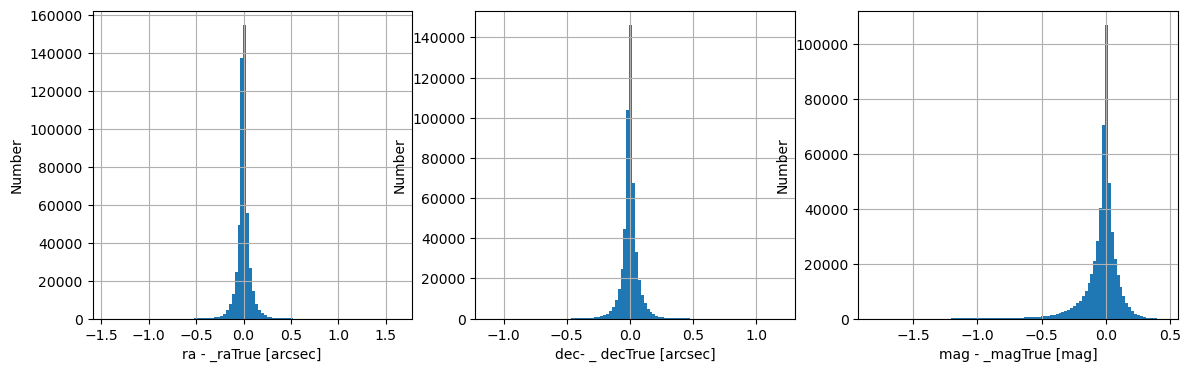

In [50]:
fig, ax = plt.subplots(1, 3, figsize=(14,4))

#ax[0].scatter(df['_raTrue'], df['ra'])
ax[0].hist(3600.*(df['ra']-df['_raTrue']), bins=100)
ax[0].set_xlabel('ra - _raTrue [arcsec]')
ax[0].set_ylabel('Number')
ax[0].grid(True)
#ax[0].set_title('_raTrue vs. ra')

#ax[1].scatter(df['_decTrue'], df['decl']
ax[1].hist(3600.*(df['decl']-df['_decTrue']), bins=100)
ax[1].set_xlabel('dec- _ decTrue [arcsec]')
ax[1].set_ylabel('Number')
ax[1].grid(True)
#ax[1].set_title('_decTrue vs. decl')

#ax[2].scatter(df['_magTrue'], df['mag'])
ax[2].hist(df['mag']-df['_magTrue'], bins=100)
ax[2].set_xlabel('mag - _magTrue [mag]')
ax[2].set_ylabel('Number')
ax[2].grid(True)
#ax[2].set_title('mag- _magTrue vs. mag')
#ax[2].invert_xaxis()
#ax[2].invert_yaxis()

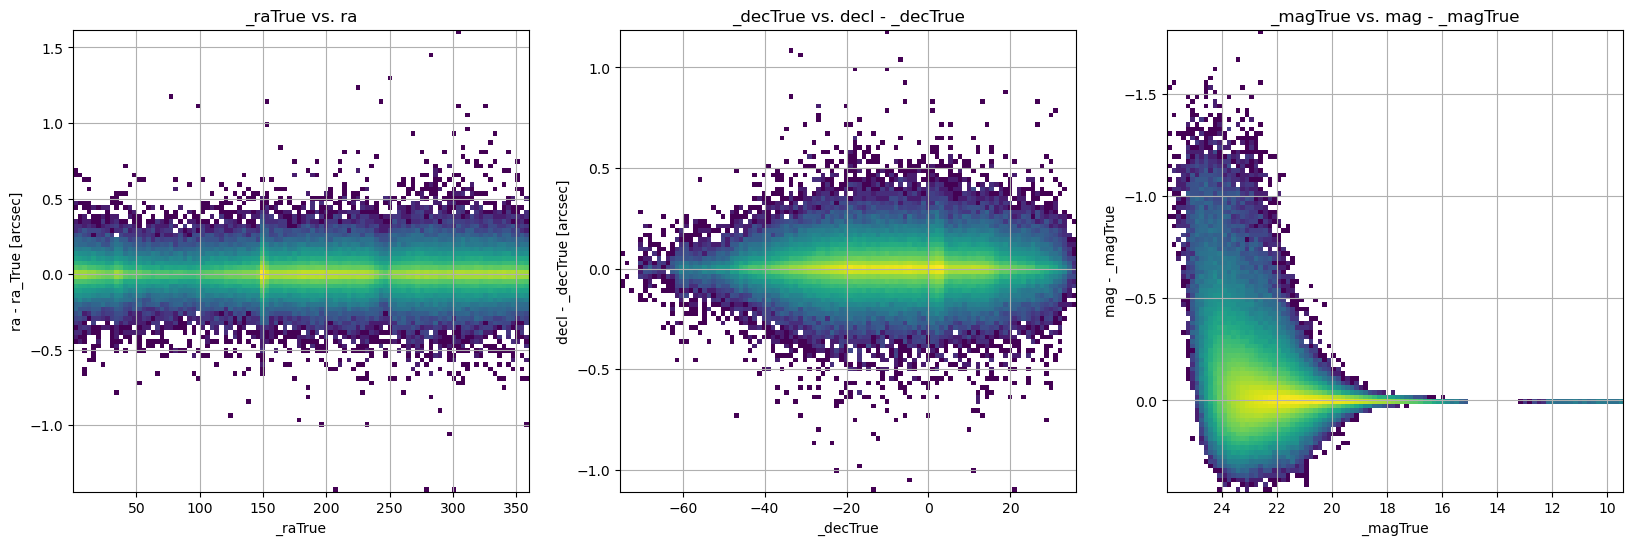

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))

ax[0].hist2d(df['_raTrue'], 3600.*(df['ra'] - df['_raTrue']), bins=100, norm='log')
ax[0].set_xlabel('_raTrue')
ax[0].set_ylabel('ra - ra_True [arcsec]')
ax[0].set_title('_raTrue vs. ra')
ax[0].grid(True)

ax[1].hist2d(df['_decTrue'], 3600.*(df['decl'] - df['_decTrue']), bins=100, norm='log')
ax[1].set_xlabel('_decTrue')
ax[1].set_ylabel('decl - _decTrue [arcsec]')
ax[1].set_title('_decTrue vs. decl - _decTrue')
ax[1].grid(True)

ax[2].hist2d(df['_magTrue'], df['mag'] - df['_magTrue'], bins=100, norm='log')
ax[2].set_xlabel('_magTrue')
ax[2].set_ylabel('mag - _magTrue')
ax[2].set_title('_magTrue vs. mag - _magTrue')
ax[2].invert_xaxis()
ax[2].invert_yaxis()
ax[2].grid(True)


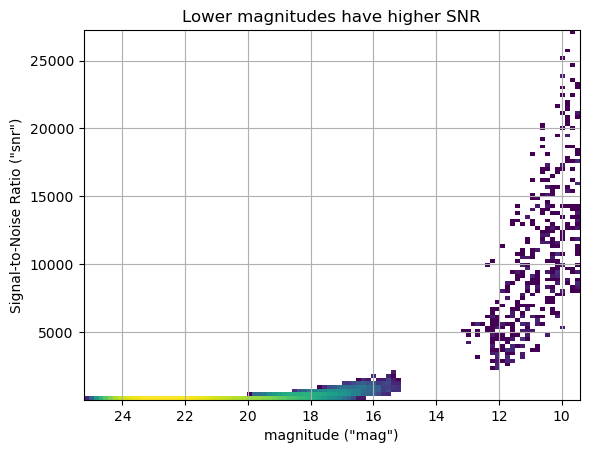

In [52]:
plt.hist2d(df['mag'], df['snr'], bins=100, norm='log')
plt.gca().invert_xaxis()
plt.xlabel('magnitude ("mag")')
plt.ylabel('Signal-to-Noise Ratio ("snr")')
plt.title('Lower magnitudes have higher SNR')
plt.grid(True)

Text(0.5, 1.0, 'ra vs. dec')

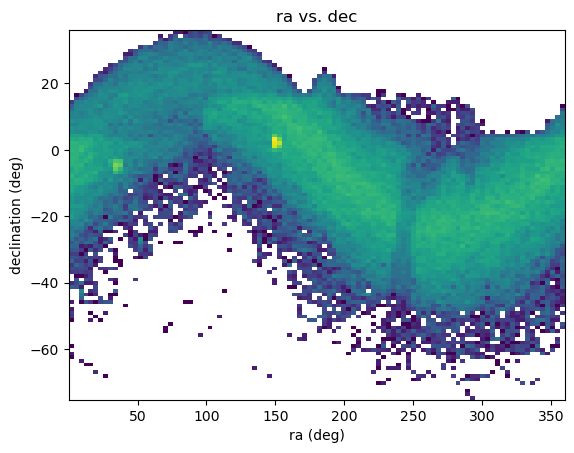

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist2d(df['ra'], df['decl'], bins=100, norm='log')
plt.xlabel('ra (deg)')
plt.ylabel('declination (deg)')
plt.title('ra vs. dec')

Try separating the filters into separate tables.

In [54]:
filter_label = ['u', 'g', 'r', 'i', 'z', 'y']
df_u = df[(df['filter'] == 'u')] 
df_g = df[(df['filter'] == 'g')]
df_r = df[(df['filter'] == 'r')]
df_i = df[(df['filter'] == 'i')]
df_z = df[(df['filter'] == 'z')] 
df_y = df[(df['filter'] == 'y')] 

The `magnitude` column encompasses all colors (there's a separate `filter` column) and, as shown below, the number of observations varies for each filter. I think color calculations would focus on ssObjectId. How do we calculate colors for objects? How many observations in how many filters? </span>

In [55]:
print("There are %d unique ssObjectId's out of %d objects" %(len(np.unique(df['ssObjectId'])), len(df)))


There are 5112 unique ssObjectId's out of 514641 objects


In [56]:
print('# of Entries for each filter:')
print(' u   g   r    i   z   y')
print(len(df_u), len(df_g), len(df_r), len(df_i), len(df_z), len(df_y))

# of Entries for each filter:
 u   g   r    i   z   y
8360 66771 179173 142721 75912 41704


In [57]:
myquery = "SELECT decl, mag, midPointTai, ra, ssObjectId" + \
        " FROM dp03_catalogs.DiaSource" + \
        " WHERE (ssObjectId =6793512588511170680)"
df = service.search(myquery).to_table().to_pandas()
df

,decl,mag,midPointTai,ra,ssObjectId
0,-21.632050,21.141586,60338.376183,257.762368,6793512588511170680
1,-21.632130,20.978247,60338.379279,257.764027,6793512588511170680
2,-21.685700,21.180084,60342.378116,259.870221,6793512588511170680
3,-21.685735,21.183739,60342.381213,259.871830,6793512588511170680
4,-21.685776,21.172150,60342.384312,259.873435,6793512588511170680
...,...,...,...,...,...
482,16.850791,20.200594,63643.073741,66.664573,6793512588511170680
483,19.616284,20.659369,63713.965215,95.171149,6793512588511170680
484,19.616278,20.765162,63713.968310,95.172755,6793512588511170680
485,19.616254,20.703131,63713.971404,95.174330,6793512588511170680


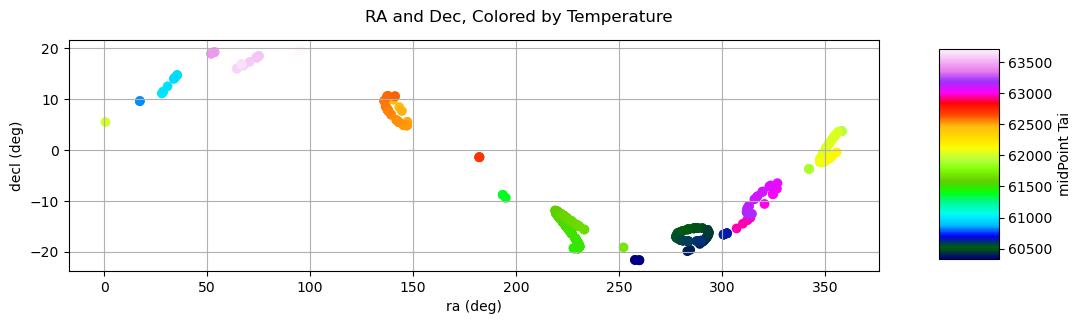

In [58]:
# These color-color plots markers are colored by effective temperature.

cmap = colormaps['gist_ncar']
fig, ax = plt.subplots(1, 1, figsize=(12,3))
im = ax.scatter(df['ra'], df['decl'], c=df['midPointTai'], cmap=cmap)
ax.set_xlabel('ra (deg)')
ax.set_ylabel('decl (deg)')

fig.suptitle('RA and Dec, Colored by Temperature')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, label='midPoint Tai')

ax.grid(True)


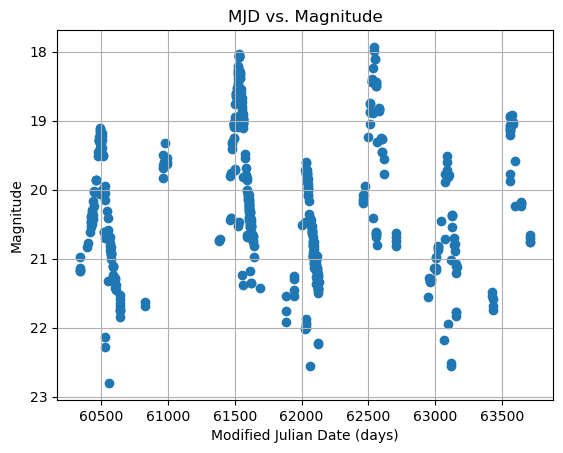

In [59]:
plt.scatter(df['midPointTai'], df['mag'])
plt.gca().invert_yaxis()
plt.xlabel('Modified Julian Date (days)')
plt.ylabel('Magnitude')
plt.title('MJD vs. Magnitude')
plt.grid(True)